In [1]:
# Code for "TSM: Temporal Shift Module for Efficient Video Understanding"
# arXiv:1811.08383
# Ji Lin*, Chuang Gan, Song Han
# {jilin, songhan}@mit.edu, ganchuang@csail.mit.edu

import torch.utils.data as data

from PIL import Image
import os
import numpy as np
from numpy.random import randint

# Add decord to read videos and not images
from decord import VideoReader
from decord import cpu, gpu
import decord
import torchvision
import torchvision.transforms as T
# Set how default a torch tensor
decord.bridge.set_bridge('torch')

In [2]:
path = '/data/imeza/ActivityNet/mkvvideosinmp4/mkv2mp4'

In [3]:
from moviepy.video.io.VideoFileClip import VideoFileClip

In [4]:
(1003//8)*8

1000

In [9]:
for i in range(100, 125, 1): print(i)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


In [4]:
class VideoRecord(object):
    def __init__(self, row):
        self._data = row

    @property
    def path(self):
        return self._data[0]

    @property
    def num_frames(self):
        return int(self._data[1])

    @property
    def label(self):
        return int(self._data[2])

In [4]:
os.listdir(path)

['v_FSe9tVYHgBc.mp4',
 'v_QSV7f5XHohE.mp4',
 'v_d79uK3AhtTU.mp4',
 'v_5iIJl-wjE9U.mp4',
 'v_jto8_gMKUjE.mp4',
 'v_etG65un_AiQ.mp4',
 'v_9vzbohxkIKA.mp4',
 'v_bmIWsU8sNlw.mp4',
 'v_mzXRehGBEOg.mp4',
 'v_JoiZmVQCLCI.mp4',
 'v_FUCYJSSqQpo.mp4',
 'v_KUorCsuIe2A.mp4',
 'v_uIOIcv5MhuA.mp4',
 'v_NsjDjDFRtWA.mp4',
 'v_UeN7XgwLkOU.mp4',
 'v_aRZd3O6-PKw.mp4',
 'v_SjbKlrUx7Do.mp4',
 'v_bVOD0M4LCEY.mp4',
 'v_pPM1jC_NlzI.mp4',
 'v_BR9dr2iOyNc.mp4',
 'v_Ub88_ql0B78.mp4',
 'v_KyDcuYjDi_Y.mp4',
 'v_O1XzCrHZm34.mp4',
 'v_wQHMoyzJx_w.mp4',
 'v_R3YoG3Hi4iI.mp4',
 'v_kTSuw4T-_Nk.mp4',
 'v_i4SNM6xSLI8.mp4',
 'v_SNuH7bpgHuY.mp4',
 'v_fjoaurNKg60.mp4',
 'v_a1ltYmbbBYI.mp4',
 'v_IYB8S2pqVCw.mp4',
 'v_c1T9LbXOVUs.mp4',
 'v_PJ72Yl0B1rY.mp4',
 'v_lu1bVIcDn4c.mp4',
 'v_SQiIQDKhnh0.mp4',
 'v_62s1ZSNLJ6g.mp4',
 'v_hKA9Ui60n-Q.mp4',
 'v_0Ffvglar63w.mp4',
 'v_1T66cuSjizE.mp4',
 'v_s3EHHOAkQYE.mp4',
 'v_AGgJVF3nT6I.mp4',
 'v_um2h6O3zjGM.mp4',
 'v_pJEOK1DbTfU.mp4',
 'v_jcX2QAiqP9U.mp4',
 'v_wB9LBEHR5-c.mp4',
 'v_I5Q0Dc

In [5]:
list_videos = os.listdir(path)

tmp = []
for video in list_videos:
    video_path = os.path.join(path, video)
    video      = VideoFileClip(video_path)
    number_fps = video.fps*video.duration
    tmp.append((video_path, number_fps, 0))

In [6]:
video_list = [VideoRecord(item) for item in tmp]

In [7]:
video_list[0].path

'/data/imeza/ActivityNet/mkvvideosinmp4/mkv2mp4/v_FSe9tVYHgBc.mp4'

In [8]:
def _parse_list_video(self):
    
    list_videos = os.listdir(self.list_file)

    tmp = []
    for video in list_videos:
        video_path = os.path.join(path, video)
        video      = VideoFileClip(video_path)
        number_fps = video.fps*video.duration
        tmp.append((video_path, number_fps, "_test_"))
    
    if not self.test_mode or self.remove_missing:
        tmp = [item for item in tmp if int(item[1]) >= 3]
    self.video_list = [VideoRecord(item) for item in tmp]

    # Without sense
#     if self.modality == 'Flow':
#         for v in self.video_list:
#             v._data[1] = int(v._data[1]) / 2
    print('video number:%d' % (len(self.video_list)))

In [9]:
def get_test_indices(record, num_segments=3, new_length=1, dense_sample=True, twice_sample=True):
    
    if dense_sample:
        sample_pos = max(1, 1 + record.num_frames - 64)
        t_stride = 64 // num_segments
        start_list = np.linspace(0, sample_pos - 1, num=10, dtype=int)
        offsets = []
        for start_idx in start_list.tolist():
            offsets += [(idx * t_stride + start_idx) % record.num_frames for idx in range(num_segments)]
        return np.array(offsets) + 1
    elif twice_sample:
        tick = (record.num_frames - new_length + 1) / float(num_segments)

        offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)] +
                           [int(tick * x) for x in range(num_segments)])

        return offsets + 1
    else:
        tick = (record.num_frames - new_length + 1) / float(num_segments)
        offsets = np.array([int(tick / 2.0 + tick * x) for x in range(num_segments)])
        return offsets + 1

In [10]:
get_test_indices(video_list[0])

array([   1,   22,   43,  229,  250,  271,  457,  478,  499,  686,  707,
        728,  914,  935,  956, 1143, 1164, 1185, 1371, 1392, 1413, 1600,
       1621, 1642, 1828, 1849, 1870, 2057, 2078, 2099])

In [11]:
video_test = video_list[0]

indices_test = get_test_indices(video_test)

vr = VideoReader(video_test._data[0], ctx=cpu(0))
frames = vr.get_batch(indices_test)

In [16]:
from torchvision import transforms

def _frames_to_pil(frames, modality='RGB'):
    
    t = transforms.ToPILImage()
    images_list = list()
    for i in range(frames.shape[0]):
        frame2pil = frames[i].permute(2, 0, 1)
        frame2pil = t(frame2pil)
        
        if modality == 'RGB' or modality == 'RGBDiff':
            frame2pil = frame2pil.convert('RGB')
            images_list.extend([frame2pil])
        elif modality == 'Flow':
            frame2pil = frame2pil.convert('RGB')
            flow_x, flow_y, _ = frame2pil.split()
            x_img = flow_x.convert('L')
            y_img = flow_y.convert('L')
            images_list.extend([x_img, y_img])
    
    return images_list

In [17]:
test_frames_to_pil = _frames_to_pil(frames)

In [18]:
test_frames_to_pil

[<PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=624x336>,
 <PIL.Image.Image image mode=RGB size=62

In [22]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

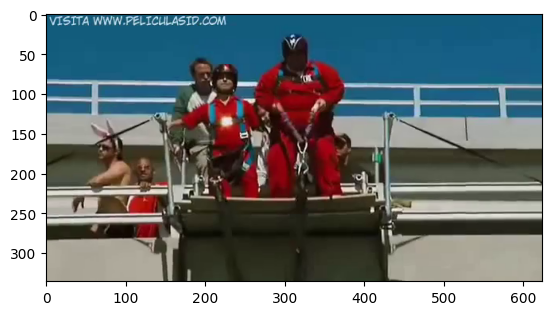

In [30]:
plt.imshow(frames[10])
plt.show

In [ ]:
def __getitem__(self, index):
        record = self.video_list[index]
        
        segment_indices = self._get_test_indices(record)
        
        return self.get(record, segment_indices)

In [72]:
from torchvision import transforms

def get(self, record, indices, new_length=1):
    
    t = transforms.ToPILImage()
    idx_image = []
    for seg_ind in indices:
        p = int(seg_ind)
        idx_image.append(p)
        for i in range(new_length):
            if p < record.num_frames:
                p += 1
                idx_image.append(p)
    indices_test.sort()
    
    # Get the frames
    vr = VideoReader(video_test._data[0], ctx=cpu(0))
    images = vr.get_batch(indices_test)
    images = _frames_to_pil(images)
    
    process_data = self.transform(images)
    return process_data, record.label

In [ ]:
def _load_image(self, directory, idx):
        if self.modality == 'RGB' or self.modality == 'RGBDiff':
            try:
                return [Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(idx))).convert('RGB')]
            except Exception:
                print('error loading image:', os.path.join(self.root_path, directory, self.image_tmpl.format(idx)))
                return [Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(1))).convert('RGB')]
        elif self.modality == 'Flow':
            if self.image_tmpl == 'flow_{}_{:05d}.jpg':  # ucf
                x_img = Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format('x', idx))).convert(
                    'L')
                y_img = Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format('y', idx))).convert(
                    'L')
            elif self.image_tmpl == '{:06d}-{}_{:05d}.jpg':  # something v1 flow
                x_img = Image.open(os.path.join(self.root_path, '{:06d}'.format(int(directory)), self.image_tmpl.
                                                format(int(directory), 'x', idx))).convert('L')
                y_img = Image.open(os.path.join(self.root_path, '{:06d}'.format(int(directory)), self.image_tmpl.
                                                format(int(directory), 'y', idx))).convert('L')
            else:
                try:
                    # idx_skip = 1 + (idx-1)*5
                    flow = Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(idx))).convert(
                        'RGB')
                except Exception:
                    print('error loading flow file:',
                          os.path.join(self.root_path, directory, self.image_tmpl.format(idx)))
                    flow = Image.open(os.path.join(self.root_path, directory, self.image_tmpl.format(1))).convert('RGB')
                # the input flow file is RGB image with (flow_x, flow_y, blank) for each channel
                flow_x, flow_y, _ = flow.split()
                x_img = flow_x.convert('L')
                y_img = flow_y.convert('L')

            return [x_img, y_img]